<a href="https://colab.research.google.com/github/utility001/cifar-10/blob/main/cifar_tl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task

+ Use a pretrained model -- MobileNetV2

## Imports

In [1]:
# !pip install --upgrade tf-keras
!pip install tensorflow==2.16.1
!pip install tensorflow_datasets
!pip install keras-tuner
!pip install scikit-learn==1.4.2
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 57.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 55.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 37.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 42.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 23.0 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Fo

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
import sys
import os
import matplotlib.pyplot as plt

In [3]:
# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

## Ingest

In [4]:
# cifar_10 details
tf.keras.datasets.cifar10.load_data?

In [5]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [6]:
X_train_full.shape, X_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

In [7]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full,
    y_train_full,
    random_state=42,
    test_size=10_000,
    shuffle=True,
    stratify=y_train_full
)

In [8]:
X_train.shape, X_val.shape, X_test.shape

((40000, 32, 32, 3), (10000, 32, 32, 3), (10000, 32, 32, 3))

In [9]:
y_train.shape, y_val.shape, y_test.shape

((40000, 1), (10000, 1), (10000, 1))

In [10]:
X_train[0].shape

(32, 32, 3)

In [11]:
X_train[0].min(), X_train[0].max()

(0, 217)

In [12]:
X_train.min(), X_train.max()

(0, 255)

In [13]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [14]:
class_names[y_train.flatten()[0]]

'frog'

In [15]:
y_train = y_train.flatten()
y_val = y_val.flatten()
y_test = y_test.flatten()
y_test[:10]

array([3, 8, 8, 0, 6, 6, 1, 6, 3, 1], dtype=uint8)

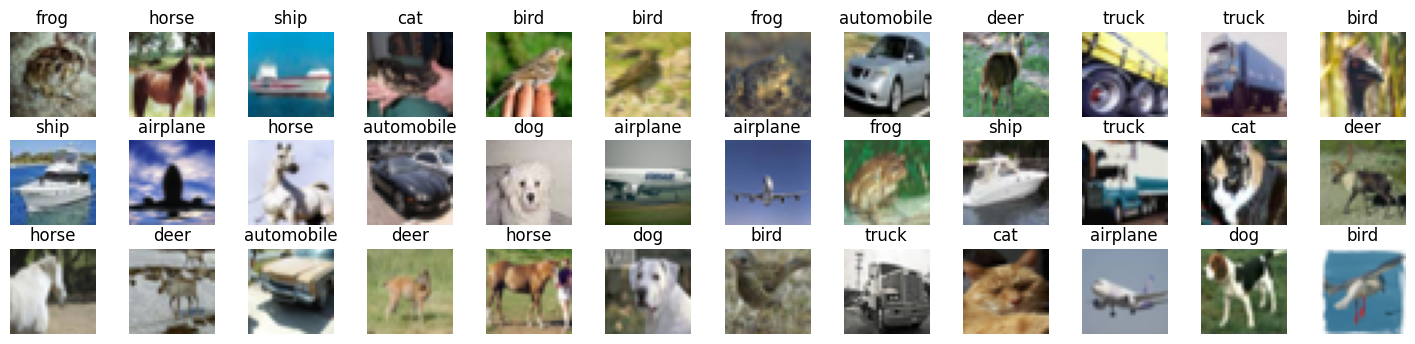

In [16]:
#  Plot a few images from the dataset
plt.figure(figsize=(18, 4))
for idx, image_data in enumerate(X_train[:36]):
    plt.subplot(3, 12, idx + 1)
    plt.imshow(X_train[idx], cmap="binary")
    plt.axis("off");
    plt.title(class_names[y_train[idx]])
plt.subplots_adjust(wspace=0.4, hspace=0.2)
plt.show();

In [17]:
def label_stats(y_train, y_val, y_test):
    # Convert numpy arrays to pandas Series
    y_train_series = pd.Series(y_train)
    y_val_series = pd.Series(y_val)
    y_test_series = pd.Series(y_test)

    # Calculate value counts and percentages for each set
    train_counts = y_train_series.value_counts()
    val_counts = y_val_series.value_counts()
    test_counts = y_test_series.value_counts()

    train_percentages = train_counts / len(y_train_series) * 100
    val_percentages = val_counts / len(y_val_series) * 100
    test_percentages = test_counts / len(y_test_series) * 100

    # Combine counts and percentages into a single DataFrame
    stats_df = pd.DataFrame({
        'Train Counts': train_counts,
        'Train Percentages': train_percentages,
        'Valid Counts': val_counts,
        'Valid Percentages': val_percentages,
        'Test Counts': test_counts,
        'Test Percentages': test_percentages
    })

    # Fill NaN values with 0 (if a label is not present in one of the sets)
    stats_df = stats_df.fillna(0)

    return stats_df

In [18]:
label_stats(y_train, y_val, y_test)

,Train Counts,Train Percentages,Valid Counts,Valid Percentages,Test Counts,Test Percentages
0,4000,10.0,1000,10.0,1000,10.0
1,4000,10.0,1000,10.0,1000,10.0
2,4000,10.0,1000,10.0,1000,10.0
3,4000,10.0,1000,10.0,1000,10.0
4,4000,10.0,1000,10.0,1000,10.0
5,4000,10.0,1000,10.0,1000,10.0
6,4000,10.0,1000,10.0,1000,10.0
7,4000,10.0,1000,10.0,1000,10.0
8,4000,10.0,1000,10.0,1000,10.0
9,4000,10.0,1000,10.0,1000,10.0


## MobileNetV2

+ Load and inspect the pretrained model

In [19]:
# Load MobileNetV2
mnv2 = tf.keras.applications.MobileNetV2(weights="imagenet")

14536120/14536120 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [20]:
len(mnv2.layers)

156

In [21]:
mnv2.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 3,538,984 (13.50 MB)

 Trainable params: 3,504,872 (13.37 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [23]:
# # Examine mobilenet
# tf.keras.utils.plot_model(
#     mnv2,
#     to_file="model_plots/MobileNetV2_architecture.png",
#     show_shapes=True,
#     show_dtype=True,
#     show_layer_activations=True,
#     dpi=60)

## Prepare the data for the task

+ Resizing the images crashed my system. So Convert it into tf.data.datasets format
+ MobileNetV2 demands the image to be [96, 128, 160, 192, 224], resize the input images
+ Apply MobileNetV2 processing steps

In [24]:
# convert to tf.data.datasets
train_set_raw = tf.data.Dataset.from_tensor_slices((X_train, y_train), name="cifar_10_train")
val_set_raw = tf.data.Dataset.from_tensor_slices((X_val, y_val), name="cifar_10_val")
test_set_raw = tf.data.Dataset.from_tensor_slices((X_test, y_test), name="cifar_10_test")

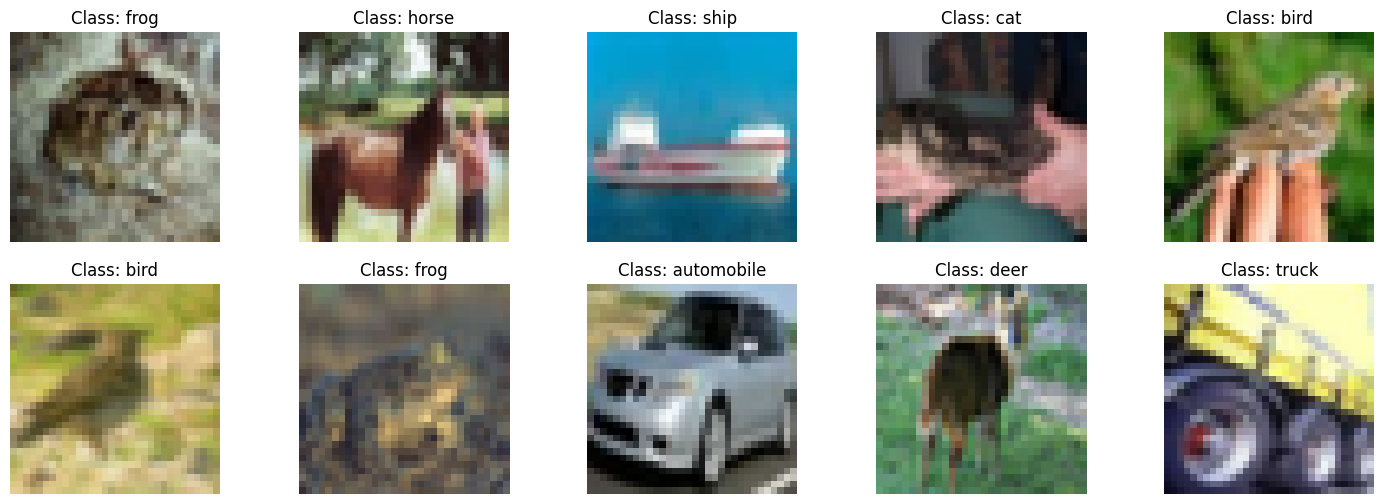

In [25]:
# Some images in the train set

plt.figure(figsize=(18, 6))
index=0
for image, label in train_set_raw.take(10):
  index += 1
  plt.subplot(2, 5, index)
  plt.imshow(image)
  plt.title(f"Class: {class_names[label]}")
  plt.axis("off")
plt.show()

In [26]:
tf.keras.backend.clear_session()

batch_size = 32
preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=96, width=96, crop_to_aspect_ratio=False),
    tf.keras.layers.Lambda(tf.keras.applications.mobilenet_v2.preprocess_input)
])

In [27]:
train_set = (train_set_raw
             .map(lambda X, y: (preprocess(X), y))
             .shuffle(1000, seed=42)
             .batch(batch_size)
             .prefetch(1)
            )
# train_set = train_set.shuffle(1000, seed=42).batch(batch_size).prefetch(1)

In [28]:
# preprocess the validation set
val_set = val_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)
test_set = test_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)

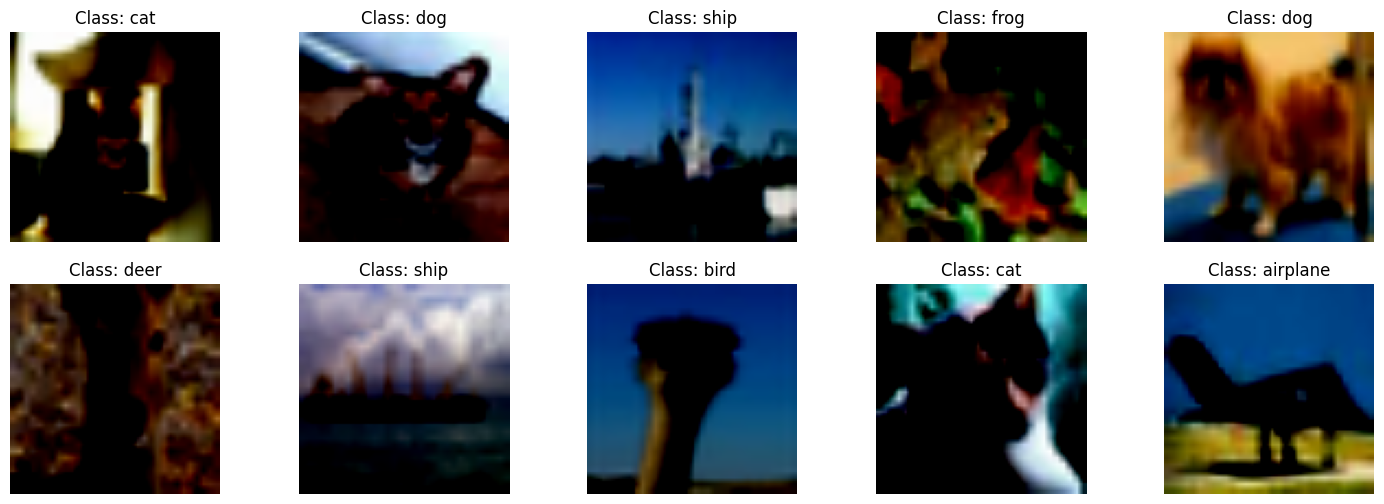

In [29]:
# View the images after resizing and batching

plt.figure(figsize=(18, 6))
index=0
for X_batch, y_batch in train_set.take(10):
  index += 1
  plt.subplot(2, 5, index)
  # print(f"max: {np.max(X_batch[index])}. min: {np.min(X_batch[index])}")
  plt.imshow(np.clip(X_batch[index], 0, 1))
  plt.title(f"Class: {class_names[y_batch[index]]}")
  plt.axis("off")

plt.show();

In [30]:
# Retrieve the first element from the dataset
for image, label in train_set.take(1):
    first_image_size = tf.shape(image[0]).numpy()
    print("First image size:", first_image_size)

First image size: [96 96  3]


In [31]:
_input_shape = list(first_image_size)
_input_shape

[96, 96, 3]

In [32]:
base_model = tf.keras.applications.MobileNetV2(
    weights='imagenet',
    input_shape=_input_shape,
    include_top=False
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [33]:
# Which layers were removed??
base_model.summary()

Model: "mobilenetv2_1.00_96"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 96, 96, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 48, 48, 32)     │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 48, 48, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 48, 48, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 48, 48, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 48, 48, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 48, 48, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 48, 48, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 48, 48, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 48, 48, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 48, 48, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 48, 48, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 49, 49, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 24, 24, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [36]:
# # Examine mobilenet
# tf.keras.utils.plot_model(
#     base_model,
#     to_file="model_plots/MobileNetV2_base.png",
#     show_shapes=True,
#     show_dtype=True,
#     show_layer_activations=True,
#     show_trainable=True,
#     dpi=60)

In [37]:
len(base_model.layers)

154

The last two layers

In [38]:
n_classes = len(class_names)
n_classes

10

In [39]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)


avg = tf.keras.layers.GlobalAveragePooling2D(keepdims=False)(base_model.output)
output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)

model = tf.keras.Model(inputs=base_model.input, outputs=output)

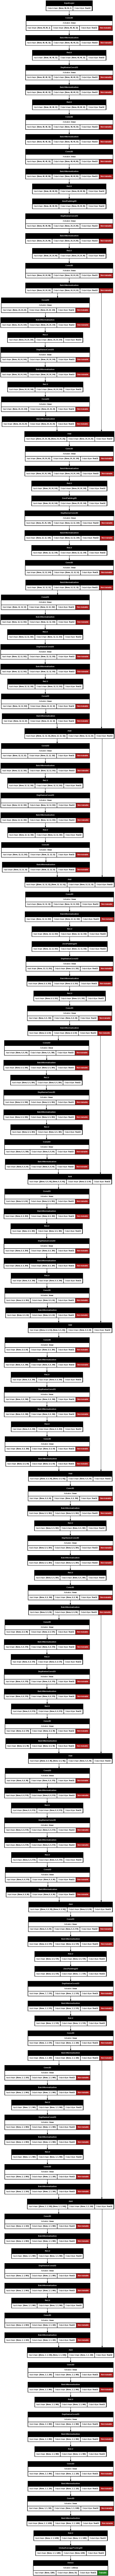

In [43]:
# View
tf.keras.utils.plot_model(
    model,
    to_file="MobileNetV2_w_added.png",
    # to_file="model_plots/MobileNetV2_w_added.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_activations=True,
    show_trainable=True,
    dpi=60)

In [41]:
# Freeze all of the weights of the pretrained layers
base_model.trainable = False

In [42]:
for layer in model.layers:
    print(f"Layer: {layer.name}, Trainable: {layer.trainable}")

Layer: input_layer_1, Trainable: False
Layer: Conv1, Trainable: False
Layer: bn_Conv1, Trainable: False
Layer: Conv1_relu, Trainable: False
Layer: expanded_conv_depthwise, Trainable: False
Layer: expanded_conv_depthwise_BN, Trainable: False
Layer: expanded_conv_depthwise_relu, Trainable: False
Layer: expanded_conv_project, Trainable: False
Layer: expanded_conv_project_BN, Trainable: False
Layer: block_1_expand, Trainable: False
Layer: block_1_expand_BN, Trainable: False
Layer: block_1_expand_relu, Trainable: False
Layer: block_1_pad, Trainable: False
Layer: block_1_depthwise, Trainable: False
Layer: block_1_depthwise_BN, Trainable: False
Layer: block_1_depthwise_relu, Trainable: False
Layer: block_1_project, Trainable: False
Layer: block_1_project_BN, Trainable: False
Layer: block_2_expand, Trainable: False
Layer: block_2_expand_BN, Trainable: False
Layer: block_2_expand_relu, Trainable: False
Layer: block_2_depthwise, Trainable: False
Layer: block_2_depthwise_BN, Trainable: False
Laye

## Warm the model up

Task
+ Train teh model for a few epochs while keeping the base model weights fixed
+ This is in order to warm up the weights and biases in the top layers
+ Use a common learning rate rather than performing hyperparameter tuning
  Tuning lr is not to important in the first training as it might have limited impact since the base layers are frozen and the top layers are too few compared to the rest of the model
+ Monitor the validation accuracy ----- Stalling model or overfitting. decrease learning rate. Underfitting. increase slightly

In [44]:
ecb = tf.keras.callbacks.EarlyStopping(patience=5)

In [45]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1, beta_1=0.9,
                                     beta_2=0.999)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [46]:
history = model.fit(train_set, validation_data=val_set, epochs=15, callbacks=[ecb])

Epoch 1/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 37s 22ms/step - accuracy: 0.7406 - loss: 11.3387 - val_accuracy: 0.7721 - val_loss: 17.2089
Epoch 2/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 29s 16ms/step - accuracy: 0.8170 - loss: 12.1794 - val_accuracy: 0.8174 - val_loss: 14.4362
Epoch 3/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.8338 - loss: 12.1019 - val_accuracy: 0.8211 - val_loss: 16.2474
Epoch 4/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 19ms/step - accuracy: 0.8441 - loss: 11.8969 - val_accuracy: 0.8122 - val_loss: 16.7903
Epoch 5/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.8479 - loss: 11.7339 - val_accuracy: 0.8248 - val_loss: 16.9653
Epoch 6/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 27s 22ms/step - accuracy: 0.8499 - loss: 12.0630 - val_accuracy: 0.8172 - val_loss: 19.7768
Epoch 7/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.8565 - loss: 12.0849 - val_accuracy: 0.8259 - val_loss: 18.3390


Now the top layers are not too bad.  
+ Let's make the top part of the base mode trainable again.
+ Tune the learning rate
+ Utilize learning rate scheduling

In [ ]:
# len(model.layers)

91

In [52]:
for layer in base_model.layers[-11:]:
    layer.trainable = True

In [53]:
for layer in model.layers:
    print(f"Layer: {layer.name}, Trainable: {layer.trainable}")

Layer: input_layer_1, Trainable: False
Layer: Conv1, Trainable: False
Layer: bn_Conv1, Trainable: False
Layer: Conv1_relu, Trainable: False
Layer: expanded_conv_depthwise, Trainable: False
Layer: expanded_conv_depthwise_BN, Trainable: False
Layer: expanded_conv_depthwise_relu, Trainable: False
Layer: expanded_conv_project, Trainable: False
Layer: expanded_conv_project_BN, Trainable: False
Layer: block_1_expand, Trainable: False
Layer: block_1_expand_BN, Trainable: False
Layer: block_1_expand_relu, Trainable: False
Layer: block_1_pad, Trainable: False
Layer: block_1_depthwise, Trainable: False
Layer: block_1_depthwise_BN, Trainable: False
Layer: block_1_depthwise_relu, Trainable: False
Layer: block_1_project, Trainable: False
Layer: block_1_project_BN, Trainable: False
Layer: block_2_expand, Trainable: False
Layer: block_2_expand_BN, Trainable: False
Layer: block_2_expand_relu, Trainable: False
Layer: block_2_depthwise, Trainable: False
Layer: block_2_depthwise_BN, Trainable: False
Laye

## Hyperparameter tuning

Tune learning schedule hyperparameters

In [55]:
import keras_tuner as kt

In [67]:
def build_model(hp):
    factor = hp.Choice("factor", values=[0.01, 0.1, 0.3, 0.5])
    # lr = hp.Choice("learning_rate", values=[0.3, 0.1, 0.01, 0.003, 0.001, 0.0001]) --- the best is

    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=factor, patience=3)

    optimizer = tf.keras.optimizers.Adam(
        learning_rate=lr??,
        beta_1=0.9, beta_2=0.999
    )

    model_clone = tf.keras.models.clone_model(model)
    model_clone.set_weights(model.get_weights())

    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=optimizer, metrics=["accuracy"])

    return model

In [68]:
random_search_tuner = kt.RandomSearch(
    build_model, objective="val_accuracy", max_trials=5, overwrite=True,
    directory="kt_parameter_tuning", project_name="random_search", seed=42)

In [ ]:
random_search_tuner.search(train_set, epochs=10,
                           validation_data=val_set)


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
0.003             |0.003             |learning_rate

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 39s 23ms/step - accuracy: 0.6957 - loss: 0.8594 - val_accuracy: 0.6979 - val_loss: 0.8678
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.7041 - loss: 0.8302 - val_accuracy: 0.7059 - val_loss: 0.8370
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 34s 18ms/step - accuracy: 0.7063 - loss: 0.8283 - val_accuracy: 0.7090 - val_loss: 0.8259
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 19ms/step - accuracy: 0.7066 - loss: 0.8268 - val_accuracy: 0.7119 - val_loss: 0.8215
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 42s 20ms/step - accuracy: 0.7088 - loss: 0.8215 - val_accuracy: 0.7120 - val_loss: 0.8203
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - accuracy: 0.7078 - loss: 0.8195 - val_accuracy: 0.7118 - val_loss: 0.8173
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 17ms/step - accuracy: 0.7093 

In [ ]:
print(5)

In [ ]:
print(5)

In [ ]:
print(5)

In [ ]:
print(5)

In [ ]:
print(5)

In [ ]:
print(5)

In [ ]:
print(5)

In [ ]:
print(5)

In [ ]:
print(5)

In [ ]:
print(5)

In [ ]:
best_trials = random_search_tuner.oracle.get_best_trials(num_trials=5)

In [ ]:
for model in best_trials:
  print(model.summary())

Trial 02 summary
Hyperparameters:
decay_rate: 0.7066230891981429
decay_steps: 63
init_l_r: 0.0031443911752710788
Score: 0.9128856658935547


## Training

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005, beta_1=0.9,
                                     beta_2=0.999)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [ ]:
history = model.fit(train_set, validation_data=valid_set, epochs=10)

Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 20s 98ms/step - accuracy: 0.6847 - loss: 0.9179 - val_accuracy: 0.5009 - val_loss: 1.4361
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 15s 94ms/step - accuracy: 0.7750 - loss: 0.7360 - val_accuracy: 0.7405 - val_loss: 0.9273
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - accuracy: 0.8096 - loss: 0.6096 - val_accuracy: 0.7296 - val_loss: 1.0920
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.8549 - loss: 0.4510 - val_accuracy: 0.8113 - val_loss: 0.7731
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.9556 - loss: 0.1860 - val_accuracy: 0.7623 - val_loss: 1.1738
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 73ms/step - accuracy: 0.9756 - loss: 0.0859 - val_accuracy: 0.8911 - val_loss: 0.4635
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - accuracy: 0.9682 - loss: 0.0941 - val_accuracy: 0.8893 - val_loss: 0.4465
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.9840 - loss: 0.0476 - val_accuracy: 0.871

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=5)

In [ ]:
for layer in model.layers[40:]:
    layer.trainable = True

In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 6,958,379 (26.54 MB)

 Trainable params: 3,075,107 (11.73 MB)

 Non-trainable params: 158,912 (620.75 KB)

 Optimizer params: 3,724,360 (14.21 MB)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.9,
                                     beta_2=0.999)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [ ]:
history = model.fit(train_set, validation_data=valid_set, epochs=50, callbacks=[early_stop])

Epoch 1/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 26s 105ms/step - accuracy: 0.9905 - loss: 0.0326 - val_accuracy: 0.8929 - val_loss: 0.3638
Epoch 2/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - accuracy: 0.9942 - loss: 0.0263 - val_accuracy: 0.8947 - val_loss: 0.3196
Epoch 3/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - accuracy: 0.9949 - loss: 0.0203 - val_accuracy: 0.9020 - val_loss: 0.3021
Epoch 4/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - accuracy: 0.9954 - loss: 0.0235 - val_accuracy: 0.9020 - val_loss: 0.3034
Epoch 5/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - accuracy: 0.9979 - loss: 0.0145 - val_accuracy: 0.9038 - val_loss: 0.3014
Epoch 6/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - accuracy: 0.9973 - loss: 0.0148 - val_accuracy: 0.9056 - val_loss: 0.3029
Epoch 7/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - accuracy: 0.9957 - loss: 0.0207 - val_accuracy: 0.9093 - val_loss: 0.2991
Epoch 8/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.9971 - loss: 0.0152 - val_accuracy: 0.905

KeyboardInterrupt: 

In [ ]:
import keras_tuner as kt

def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=2, max_value=5)

    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2,
                             sampling="log")

    initializer = hp.Choice("kernel_initializer", values=["he_normal", "he_uniform"])
    if initializer == 'he_normal':
        initializer = tf.keras.initializers.he_normal()
    elif initializer == 'he_normal':
        initializer = tf.keras.initializers.he_uniform()

    activation = hp.Choice('activation', values=['relu', 'leaky_relu', 'swish'])
    if activation == 'relu':
        activation = tf.keras.activations.relu
    elif activation == 'leaky_relu':
        activation = tf.keras.activations.leaky_relu
    elif activation == 'swish':
        activation = tf.keras.activations.swish

    optimizer = hp.Choice("optimizer", values=["sgd", "adam"])
    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(shape=input_shape))
    model.add(tf.keras.layers.Flatten())
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(
            200, #200 neurons fixed
            activation=activation,
            kernel_initializer=initializer
        ))
    model.add(tf.keras.layers.Dense(10, activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model




random_search_tuner = kt.RandomSearch(
    build_model, objective="val_accuracy", max_trials=20, overwrite=False,
    directory="my_fashion_mnist", project_name="random_search", seed=42)


random_search_tuner.search(X_train, y_train, epochs=10,
                           validation_data=(X_val, y_val))


best_trials = random_search_tuner.oracle.get_best_trials(num_trials=5)

best_trials[0].summary()

best_trials[1].summary()

This model should reach around 92% accuracy on the test set, in just a few
minutes of training (with a GPU).

If you tune the hyperparameters, lower the learning rate, and train for quite a bit longer, you should be able to reach 95% to 97%.

With that, you can start training amazing image classifiers on your own images and classes!

In [ ]:
model.save("adam_flower_classifier.keras")

# Evaluation

In [ ]:
saved_model = tf.keras.models.load_model("saved_model/adam_flower_classifier.keras")

In [ ]:
batch_size = 10

In [ ]:
loss, acc = saved_model.evaluate(valid_set)

I0000 00:00:1715456611.117863  136408 service.cc:145] XLA service 0x7fbf5007be40 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1715456611.117912  136408 service.cc:153]   StreamExecutor device (0): Host, Default Version
2024-05-11 20:43:31.693751: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1715456615.168700  136408 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


56/56 ━━━━━━━━━━━━━━━━━━━━ 198s 3s/step - accuracy: 0.8999 - loss: 0.2853


In [ ]:
true_class_names = []
predicted_class_names = []

# Get the  predictions and their original class_names
for image, label in valid_set:
    # Get pred probas
    pred= saved_model.predict(image)
    # convert them to actual classes
    predicted_class_names.extend(pred.argmax(axis=1))
    # get the true label
    true_class_names.extend(label)

56/56 ━━━━━━━━━━━━━━━━━━━━ 191s 3s/step


In [ ]:
np_true_class_names = np.array(true_class_names)
np_true_class_names[:10]

array([0, 0, 0, 0, 0, 4, 0, 2, 3, 1])

In [ ]:
np_predicted_class_names = np.array(predicted_class_names)
np_predicted_class_names[:10]

array([0, 2, 0, 0, 0, 4, 4, 2, 3, 1])

In [ ]:
misclassified = np.flatnonzero(np_true_class_names != np_predicted_class_names)
# how many
print(len(misclassified))
# View 10
misclassified[:10]

48


array([ 1,  6, 23, 26, 28, 47, 51, 63, 84, 88])

In [ ]:
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

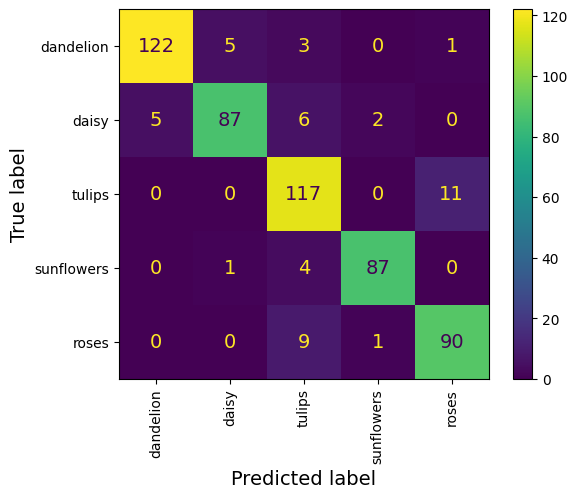

In [ ]:
ConfusionMatrixDisplay.from_predictions(
    y_true = true_class_names,
    y_pred = predicted_class_names,
    display_class_names=class_names,
    xticks_rotation="vertical"
);

# Predictions with Gradio

In [ ]:
def image_pred(image, crop_to_aspect_ratio=True):
    # convert the image to a numpy array
    image = np.array(image)

    # Add an axis. To represent batch size. Models are trained with an extra axis at the front to represent batch size
    image = image[np.newaxis, ...]

    # resize the image
    resize = tf.keras.layers.Resizing(
        height=224,
        width=224,
        crop_to_aspect_ratio=crop_to_aspect_ratio
    )
    res_img = resize(image)

    # preprocess the image
    prep_img = tf.keras.applications.mobilenet.preprocess_input(res_img)

    # pred_probas
    pred_probas = saved_model.predict(prep_img)
    # Get the value of the max predicion probability
    max_pred_proba = np.max(pred_probas)
    # get the ineex of the max prediction probability
    pred = np.argmax(pred_probas, axis=1)
    # label
    label = class_names[pred[0]]

    # Convert the transformed image to an array
    res_array = np.array(res_img)
    # remove the first axis that was added above
    squeeze = np.squeeze(res_array, axis=0)
    # divide by max value
    plot_image = squeeze/250
    # clip
    clip = np.clip(plot_image, 0, 1)

    return clip, f"{label} {max_pred_proba}%"

In [ ]:
# from PIL import Image

# image_path = "sample_image/ss.jpg"
# image = Image.open(image_path)

# # Convert  to np array
# image_array = np.array(image)

# image_array.shape

In [ ]:
# t, u = image_pred(image_array)
# t

In [ ]:
import gradio as gr

In [ ]:
# Create the Gradio interface
interface = gr.Interface(
    fn=image_pred,
    inputs=[
        gr.Image(value="Image", type="numpy"),
        gr.Checkbox(label="Crop to aspect ratio")
    ],
    outputs=[
        gr.Image(value="Image", type="numpy", height=250, width=250),
        gr.Text(label="Prediction"),
    ],
    title="MobileNet 50 pretrained model. Trained on Flower dataset",
    description="""
    Predict 5 species of flower
    """
)

# Run the Gradio interface
interface.launch()

Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step
